# We are One Big Group and This is our Jupyter notebook

We did our analysis of the best neighborhood in Pittsburgh based on the amount of crimes per person in each neighborhood. We used the [Pittsburgh Police Crime Blotter](https://data.wprdc.org/dataset/uniform-crime-reporting-data), and the [2010 SNAP census](https://data.wprdc.org/dataset/pgh).

The Police Crime blotter data follows a crime reporting standard that ranks each crime with a number in a hierarchy. We used this hierarchy to weight which crimes would we worth more or less compared to the others. 

## Crimes worth 2 points
1. Criminal Homicide
2. Forcible Rape
3. Robbery
4. Aggravated Assault
5. Burglary 
6. Larceny-theft (except motor vehicle theft)
7. Motor Vehicle Theft
8. Arson
----------------------------------------
## Crimes worth one point
9. Other Assaults
10. Forgery and Counterfeiting
11. Fraud
12. Embezzlement
13. Stolen Property:  Buying, Receiving, Possessing
14. Vandalism
15. Weapons:  Carrying, Possessing, etc.
16. Prostitution and Commercialized Vice
17. Sex Offenses
18. Drug Abuse Violations
19. Gambling
20. Offenses Against the Family and Children
21. Driving Under the Influence
22. Liquor Laws
23. Drunkenness
24. Disorderly Conduct
25. Vagrancy
26. All Other Offenses
27. Suspicion
28. Curfew and Loitering Laws—(Persons under 18)
29. Runaways—(Persons under 18)

-------------------------
The following code was what we wrote to try and organize these data so that we could follow through to process it:

In [28]:
import pandas as pd

crimes = pd.read_csv("crime.csv")
census = pd.read_csv("population-density.csv")


scores = { i : 0 for i in census["Neighborhood"].tolist() }


for i in range(len(crimes)):
    try:
        if crimes["HIERARCHY"][i] < 9:
            scores[crimes["INCIDENTNEIGHBORHOOD"][i]] += 2
        else:
            scores[crimes["INCIDENTNEIGHBORHOOD"][i]] += 1
    except:
        pass

big_hoods = scores.copy()
    
for i in range(len(census)):
    scores[census["Neighborhood"][i]] = scores[census["Neighborhood"][i]] / int(census["Pop. 2010"][i])
    big_hoods[census["Neighborhood"][i]] = big_hoods[census["Neighborhood"][i]] / int(census["Pop. 2010"][i])
    
    if int(census["Pop. 2010"][i]) < 100:
        big_hoods.pop(census["Neighborhood"][i])
    
scores = pd.DataFrame.from_dict(scores, orient='index', columns=["CPC"])   
big_hoods = pd.DataFrame.from_dict(big_hoods, orient='index', columns=["CPC"])   
big_hoods



,CPC
Allegheny Center,2.887460
Allegheny West,2.329004
Allentown,1.557600
Arlington,0.871589
Arlington Heights,1.590164
Banksville,0.276303
Bedford Dwellings,1.354409
Beechview,0.460246
Beltzhoover,0.692468
Bloomfield,0.901090


This looks good, we've accounted for small neighborhoods looking disproportionately criminal. BUT Mount Oliver is reported in THREE different names in the crime blotter. To account for this we wrote the following code, which also removes neighborhoods that are not listed in both the census and the crime blotter:

In [50]:
#This is going to fix the mount oliver problem
crim = pd.read_csv("crime.csv", index_col="INCIDENTNEIGHBORHOOD")

crim=crim.drop(["CCR","INCIDENTTIME","CLEAREDFLAG","INCIDENTZONE","INCIDENTHIERARCHYDESC","OFFENSES","COUNCIL_DISTRICT","PUBLIC_WORKS_DIVISION"], axis=1)

row=0
while row<len(crim):
    if crim.iloc[row].HIERARCHY >8:
        crim.iloc[row].HIERARCHY=1
        row=row+1
    else:
        crim.iloc[row].HIERARCHY=2
        row=row+1

crim = crim.groupby("INCIDENTNEIGHBORHOOD").sum()

cen = pd.read_csv("population-density.csv",index_col="Neighborhood")
cen = cen[['Pop. 2010']]

cen=cen.groupby("Neighborhood").sum()


mtolicrimes=(crim.loc["Mount Oliver"].HIERARCHY+crim.loc["Mt. Oliver Neighborhood"].HIERARCHY+crim.loc["Mt. Oliver Boro"].HIERARCHY)



drop_crimes=crim.drop(['Central North Side', 'Golden Triangle/Civic Arena',"Mount Oliver", "Mt. Oliver Neighborhood", "Mt. Oliver Boro", 'Outside City',
                 'Outside County', 'Outside State', 'Troy Hill-Herrs Island'])

mtoli = pd.DataFrame([["Mt. Oliver",mtolicrimes]], columns=(["INCIDENTNEIGHBORHOOD","HIERARCHY"]))
mtoli=mtoli.groupby("INCIDENTNEIGHBORHOOD").sum()


drop_crimes=drop_crimes.append(mtoli)

drop_crimes=drop_crimes.sort_index()

neighborhoodlist = []
for val in drop_crimes.index:
    neighborhoodlist.append(val)


myList=[]
i=0
while i<len(drop_crimes):
    myList.append(drop_crimes.iloc[i].HIERARCHY/cen["Pop. 2010"][i])
    i+=1

data = {'Neighborhood':neighborhoodlist, 'Crimes_Per_Person':myList}
dataFrame = pd.DataFrame(data)



In [51]:
#now we filter out the neighborhoods that are too small

dataFrame = dataFrame.set_index("Neighborhood")

row=0
while row<len(cen):
    if cen.iloc[row].iloc[0]<100:     
        dataFrame=dataFrame.drop([cen.index[row]])
    row=row+1

dataFrame=dataFrame.sort_values("Crimes_Per_Person")

And just like that, we can move on to visualizing our data, with our very clean, very accurate Data Frame named dataFrame because it's our final Data Frame

--------------------------------------------------------

# Data Visualization

First off here's our data all sorted from least Crime Per Person (CPP) to the most crimes per person for residential neighborhoods (neighborhoods with population larger than 100). We figured if there's less than 100 people, it's not a residential area, and crime statistics are unfair to compare. This ended up only filtering out Chateau and South Shore, which are warehouse/industrial neighborhoods.

In [64]:
dataFrame

,Crimes_Per_Person
Neighborhood,
New Homestead,0.223232
Swisshelm Park,0.249816
Terrace Village,0.262392
Banksville,0.276303
Squirrel Hill North,0.292352
Duquesne Heights,0.298969
Stanton Heights,0.306020
Greenfield,0.322183
Morningside,0.340705


This is kind of a lot to deal with, but we can clearly see that New Homestead has the lowest CPP. Let's take a look at just the 5 neighborhoods with the lowest CPP.

In [53]:
top_five = dataFrame.nsmallest(5, 'Crimes_Per_Person')

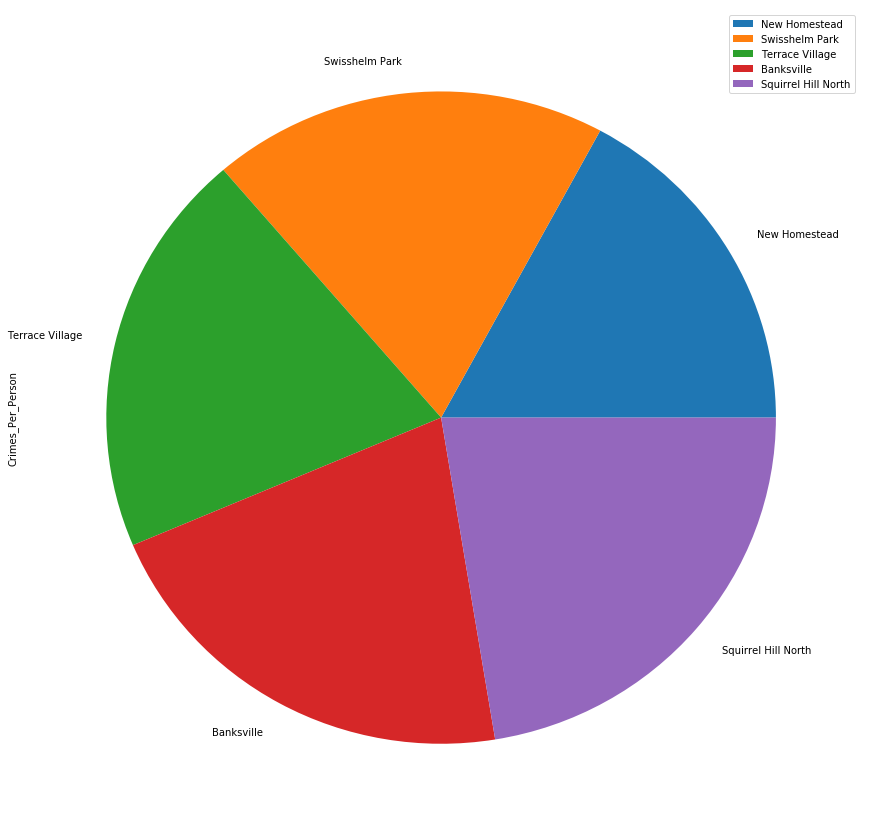

In [55]:
plot = top_five.plot.pie(y="Crimes_Per_Person",figsize=(15,15),subplots=True)

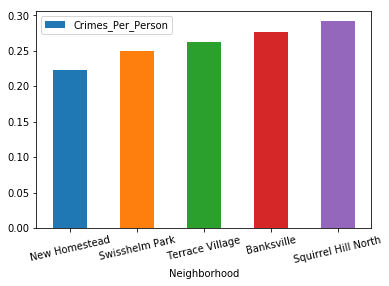

In [65]:
zi = top_five.plot.bar(y="Crimes_Per_Person",rot=13)

Now let's see how everything compares all together

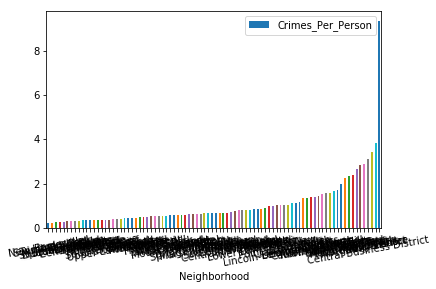

In [66]:
ax = dataFrame.plot.bar(y='Crimes_Per_Person', rot=10)

Oof that's messy. Let's just look at the 5 worst neighborhoods for CPP

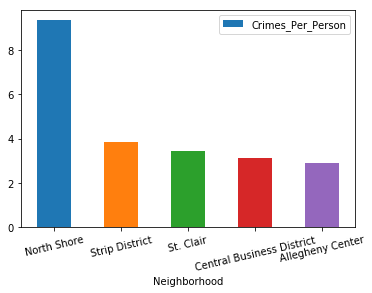

In [63]:
worst_five = dataFrame.nlargest(5, 'Crimes_Per_Person')
wf = worst_five.plot.bar(y="Crimes_Per_Person", rot=13)

Sorry North Shore! Looks Like you're the worst.

---------------------------------------------
# The Best Neighborhood

The best neighborhood by our metric is New Homestead. This is because it has the lowest amount of crimes per person of any neighborhood in Pittsburgh. Even though it is by a narrow margin, with many neighborhoods close behind, it is clearly the best by our metric. 

---------------------------------

# Conclusions

**Alex**: This data driven approach creates a very different result than my personal favorite neighborhood. This is because I haven't gotten out of Oakland much, but Oakland is my favorite. It is a pretty safe neighborhood, there's a bunch of restraunts and shops, and it's where I go to school, so I feel an attachment to it. Even though it ranks higher in crimes per person, I still feel safe and I don't think that feeling of safety is naive. I still live very carefully and always keep my head on a swivel. Maybe if I lived in New Homestead, the knowledge of the low crime would make me less careful and would actually lead to more dangerous situations.

**Matt**: I think that our approach provides a good start towards identifying the best neighborhood Pittsburgh, but doesn't get anywhere close to the full story. There are many other things that decide whether or not a neighborhood is desirable beyond just the crime rate. That being said, I do beleive that as a single metric, it is quite useful in deciding where to live, as crime rate is indicative of the overall look and feel of a neighborhood. Personally, I can not speak to its accuracy since I have never been to New Homestead. However, the neighborhoods I have been to, including shadyside, the north shore, squirrel hill, etc, all seem to be logically placed, so I can say with some certainty that the our model creates a good approximation of the most desirable neighborhoods. For this reason I would have to agree with its conclusion of New Homestead

**Sydni**:My personal favorite neighborhood in Pittsburgh is Shadyside (Oakland is a close second). I've never been to New Homestead before, but I have been to Homestead and because of this I was initially surprised by New Homestead's excellent ranking. This summer I was watching my sister's softball tournament in Homestead and there were gunshots fired down the street from where they were playing and if the girls wanted to use the bathroom they needed to be escorted by one of the dads there. New Homestead is relatively close to Homestead, which I would have guessed meant it would have similar crime rates to Homestead. If we did this project again, I would be interested to see how the geographic location of different neighborhoods relates to their crime rate. I like Shadyside and Oakland because of all the stores, restaurants, and things to do in the area, so I would like to visit New Homestead and see if it has similar amenities. However, places like the Strip District also have a lot of things to do but I do not feel safe there at all, so I think using crime rate as a measurement for the best neighborhood was a good decision. 

**Zach**: Being from Pittsburgh my entire life, I have a decent idea of what neighborhoods are better than others. While New Homestead seems to be the best neighborhood according to our results, I have to disagree based on my knowledge of the area. Homestead as a whole is usually tagged negatively because it is a low-income area with a high crime rate. New Homestead being close to that more troubled area makes me feel a bit uneasy, even if I have not been there. From the list, I prefer Brookline because I spend a lot of time there, with my grandparents and best friend living in that area. I have felt very safe and would choose this as my Best Neighborhood for this project. I think we use a good metric, but there are other factors we have to consider that would enhance our knowledge of the neighborhoods around Pittsburgh.

**Birizibe**: